In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
def pg_hook():
    return psycopg2.connect(dbname="mydb", user="myuser", password="mypassword", host='localhost', port=5432)
conn = pg_hook()
conn.autocommit = True


In [3]:
q_pg = """
SELECT * FROM mlm.ytrue
INNER JOIN mlm.scores USING(puid);
"""
df = pd.read_sql(q_pg, conn)
df.set_index('puid', drop=True, inplace=True)
y_true = df['y_true'].copy()
df.drop(['create_ts', 'update_ts', 
        'y_true'], axis=1, inplace=True)

In [4]:
q_sbs = """
SELECT * FROM mlm.ytrue
INNER JOIN exploration.simplesbs USING(puid);
"""
dfsbs = pd.read_sql(q_sbs, conn).set_index('puid', drop=True)

In [5]:
from fuzzywuzzy.fuzz import token_set_ratio
Xfwz = pd.DataFrame(index=dfsbs.index)
Xfwz['firstnames_tokenset'] = dfsbs[['firstnames_source', 'firstnames_target']].apply(lambda r: token_set_ratio(*r)/100, axis=1)

In [6]:
X= df[['firstnames_tfidf', 'surname_tfidf', 'locality_tfidf',
       'postalcodelong_tfidf', 'route_tfidf', 'title_tfidf',
       'firstnames_levenshtein', 'surname_levenshtein', 'route_levenshtein',
       'locality_levenshtein', 'postalcodelong_levenshtein',
       'firstnames_trg_metaphone', 'surname_trg_metaphone',
       'locality_trg_metaphone', 'route_trg_metaphone',
       'phone_exact', 'email_exact', 'ni_number_exact', 'geo_score_ths']].copy()
X['firstnames_tokenset'] = Xfwz['firstnames_tokenset']
X = X.fillna(0)

In [7]:
X.describe().transpose().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
postalcodelong_tfidf,1610.0,12.905111,5.338980,0.0,13.428352,15.094787,15.944765,22.122709
route_tfidf,1610.0,7.994895,6.010342,0.0,0.000000,9.522917,11.831315,31.389122
surname_tfidf,1610.0,7.265784,3.340923,0.0,6.341908,8.195763,9.549666,15.271128
locality_tfidf,1610.0,6.417626,3.219988,0.0,5.023827,6.624468,8.410403,27.038492
firstnames_tfidf,1610.0,5.935481,5.184463,0.0,0.000000,4.724084,9.384070,27.788972
locality_levenshtein,1610.0,0.953003,0.195305,0.0,1.000000,1.000000,1.000000,1.000000
locality_trg_metaphone,1610.0,0.946164,0.223072,0.0,1.000000,1.000000,1.000000,1.000000
postalcodelong_levenshtein,1610.0,0.893146,0.233051,0.0,1.000000,1.000000,1.000000,1.000000
surname_levenshtein,1610.0,0.864097,0.313833,0.0,1.000000,1.000000,1.000000,1.000000
surname_trg_metaphone,1610.0,0.839991,0.357467,0.0,1.000000,1.000000,1.000000,1.000000


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score,\
accuracy_score, precision_score, confusion_matrix, f1_score

In [13]:
pipe_model= Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])

param_grid = {
    'gb__min_samples_split': [3, 4, 8], 
    'gb__n_estimators' : [ 75, 100, 150],
    'gb__max_depth': [8, 10, 12],
    'gb__max_features': [3,  5, 7]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


In [14]:
def grid_search_wrapper(X_train, y_train, X_test, y_test, clf, param_grid, refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of model optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by=f'mean_test_{refit_score}', ascending=False)
    return grid_search, results

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true)
grid_model, results_model = grid_search_wrapper(X_train, y_train, X_test, y_test, pipe_model, param_grid, 'recall_score')
results_model[['mean_test_precision_score','mean_test_recall_score','mean_test_accuracy_score']].head(4)

Best params for recall_score
{'gb__max_depth': 8, 'gb__max_features': 3, 'gb__min_samples_split': 3, 'gb__n_estimators': 75}

Confusion matrix of model optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       146         5
pos         5       247


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
0,0.983330,0.985835,0.981770
13,0.984662,0.985835,0.982603
29,0.983330,0.985835,0.981770
61,0.983330,0.985835,0.981770


In [29]:
results_model[['mean_test_precision_score','mean_test_recall_score','mean_test_accuracy_score']].describe()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
count,81.000000,81.000000,81.000000
mean,0.983905,0.983786,0.980941
std,0.001125,0.001558,0.001031
min,0.981841,0.980181,0.978457
25%,0.983291,0.982998,0.980117
50%,0.983330,0.984427,0.980944
75%,0.984660,0.984427,0.981770
max,0.986086,0.985835,0.982603


In [17]:
pipe_grid = grid_model.best_estimator_
y_pred=pipe_grid.predict(X_test)
print(f"recall score:{recall_score(y_test, y_pred)}")
print(f"precision_score:{precision_score(y_test, y_pred)}")
print(f"f1_score:{f1_score(y_test, y_pred)}")

recall score:0.9801587301587301
precision_score:0.9801587301587301
f1_score:0.9801587301587301


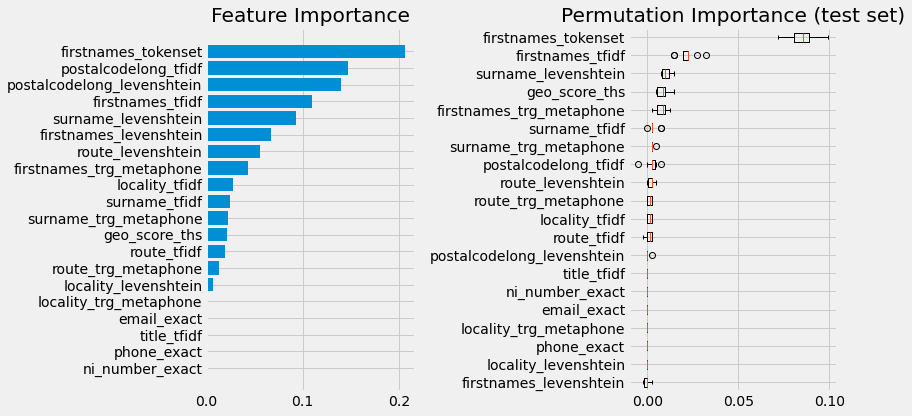

In [18]:
from sklearn.inspection import permutation_importance
feature_importance = pipe_grid.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
result = permutation_importance(pipe_grid, X_test, y_test, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [19]:
with open('/Users/pogier/Documents/63-Elk/dockersetup/shared_volume/ml_models/gradient_boosting.pickle', 'wb') as f1:
    pickle.dump(pipe_grid, f1)

In [20]:
import json
with open('/Users/pogier/Documents/63-Elk/dockersetup/shared_volume/ml_models/gradient_boosting.txt', 'w') as f2:
    f2.write(','.join(X.columns))
    f2.write('\n')
    json.dump(grid_model.best_params_, f2)

## Adjusting the thresholds for sending low-confidence matches to TDS

### We are using the full model to make sure not to forget anything

In [21]:
y_pred = pd.Series(data=pipe_grid.predict(X_test), index=X_test.index, name='y_pred')
y_proba = pd.Series(data=pipe_grid.predict_proba(X_test)[:,1], index=X_test.index, name='y_proba')
dfp = pd.concat([y_test, y_pred, y_proba], ignore_index=False, axis=1)
fn = dfp.loc[(dfp['y_pred']==0) & (dfp['y_true']==1)].index
fp = dfp.loc[(dfp['y_pred']==1) & (dfp['y_true']==0)].index
print(f"{y_pred.sum()} positive pairs correctly identified out of {len(y_pred)} possible pairs")
print(f"precision_score:{precision_score(y_test, y_pred)}")
print(f"recall_score:{recall_score(y_test, y_pred)}")
print(f"{len(fn)} false negatives :{fn.values}")
print(f"{len(fp)} false postives :{fp.values}")

252 positive pairs correctly identified out of 403 possible pairs
precision_score:0.9801587301587301
recall_score:0.9801587301587301
5 false negatives :['174739-411133' '353366-599740' '237486-237487' '573013-573014'
 '427167-608551']
5 false postives :['285743-285744' '314038-314039' '312235-555140' '340604-340605'
 '29587-29588']


### Lower threshold calculation: All pairs above should be considered potential matches
- increases the number of potential matches --> Increase false positives
- Decreases (and ideally eliminate) the matches missed --> Decreases false negatives

In [22]:
print(dfp.loc[fn]['y_proba'].min())
dfp.loc[fn]['y_proba']

0.008535299570919381


puid
174739-411133    0.294100
353366-599740    0.197411
237486-237487    0.015370
573013-573014    0.008535
427167-608551    0.169303
Name: y_proba, dtype: float64

In [1]:
dfsbs.loc[fp]

NameError: name 'dfsbs' is not defined

In [24]:
X.loc[fn]

,firstnames_tfidf,surname_tfidf,locality_tfidf,postalcodelong_tfidf,route_tfidf,title_tfidf,firstnames_levenshtein,surname_levenshtein,route_levenshtein,locality_levenshtein,postalcodelong_levenshtein,firstnames_trg_metaphone,surname_trg_metaphone,locality_trg_metaphone,route_trg_metaphone,phone_exact,email_exact,ni_number_exact,geo_score_ths,firstnames_tokenset
puid,,,,,,,,,,,,,,,,,,,,
174739-411133,4.299834,9.721084,6.367420,15.615111,13.052825,0.0,0.277778,1.0,1.0,1.0,1.0,0.500000,1.0,1.0,1.0,0,0,0,1.0,0.43
353366-599740,0.000000,8.223223,5.820731,14.594807,9.418873,0.0,0.312500,1.0,1.0,1.0,1.0,0.500000,1.0,1.0,1.0,0,0,0,1.0,0.48
237486-237487,0.000000,9.344338,9.793944,14.956687,9.996947,0.0,0.333333,1.0,1.0,1.0,1.0,0.333333,1.0,1.0,1.0,0,0,0,1.0,0.44
573013-573014,0.000000,9.652520,7.045813,16.600715,11.252653,0.0,0.461538,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0,0,0,1.0,0.42
427167-608551,0.000000,9.336521,7.691174,17.284225,14.689146,0.0,0.444444,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0,0,0,1.0,0.62


In [25]:
ths_recall = 0.1
y_trecall = (y_proba>=ths_recall).astype(int)
total_fn = sum(y_test.multiply((~y_trecall.astype(bool)).astype(int)))
total_fp = sum(y_trecall.multiply((~y_test.astype(bool)).astype(int)))
print(f"{total_fp} false positives: precision_score:{precision_score(y_test, y_trecall)}")
print(f"{total_fn} false negatives: recall_score:{recall_score(y_test, y_trecall)}")

8 false positives: precision_score:0.9689922480620154
2 false negatives: recall_score:0.9920634920634921


### Higher Threshold

In [26]:
dfp.loc[fp]['y_proba'].max()

0.9991521844766597

In [27]:
ths_sure = 0.85
y_tsure = (y_proba>=ths_sure).astype(int)
dfp['trecall']=y_trecall
dfp['tsure']=y_tsure
dfp['decision']=(dfp['trecall']+dfp['tsure']).map({0:'ignore', 1:'TDS', 2:'Sure'})

In [28]:
dfp[['decision', 'y_true']].pivot_table(index='decision', columns=['y_true'], aggfunc=len).fillna(0)

y_true,0,1
decision,,
Sure,5,247
TDS,3,3
ignore,143,2


#### 